### Задача 3.
Вам предлагается изучить и сравнить свойства линейных регрессионных моделей: обычной и с регуляризациями -- Lasso, Ridge, Elastic Net.  
При выполнении задания воспользуйтесь готовыми реализациями методов в sklearn.

Скачайте данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018`</a>, в которых используйте следующие столбцы:
* `Cost of Living Index` --- является относительным показателем цен на потребительские товары, включая продукты, рестораны, транспорт и коммунальные услуги. Cost of Living Index не включает расходы на проживание, такие как аренда или ипотека. Если город имеет индекс стоимости жизни 120, это означает, что Numbeo оценивает его на 20% дороже, чем Нью-Йорк.

* `Rent Index` --- это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком. Если индекс арендной платы равен 80, Numbeo оценивает, что цена аренды в этом городе в среднем на 20% меньше, чем цена в Нью-Йорке.

* `Cost of Living Plus Rent Index` --- это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

* `Restaurant Price Index` --- сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорк.

* `Local Purchasing Power Index` --- показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если внутренняя покупательная способность составляет 40, это означает, что жители этого города со средней зарплатой могут позволить себе покупать в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой по Нью-Йорку.

* `Groceries Index` --- это оценка цен на продукты в городе по сравнению с Нью-Йорком. Для расчета этого раздела Number использует веса товаров в разделе "Рынки" для каждого города.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.pipeline import Pipeline

import scipy.stats as sps

import seaborn as sns
import warnings

sns.set('notebook', font_scale=1.6, palette='Set1')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('cost-of-living-2018.txt', sep='\t')
data = data[[
    'Cost of Living Index',
    'Rent Index',
    'Cost of Living Plus Rent Index',
    'Restaurant Price Index',
    'Local Purchasing Power Index',
    'Groceries Index'
]]
data.head()

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Restaurant Price Index,Local Purchasing Power Index,Groceries Index
0,145.43,110.87,128.76,158.75,112.26,143.47
1,141.25,66.14,105.03,135.76,142.70,149.86
2,134.83,71.70,104.38,129.74,130.96,138.98
3,130.68,49.68,91.61,127.22,139.01,127.54
4,128.03,43.57,87.30,119.48,112.71,132.70


**1.** Задача заключается в построении предсказания `Groceries Index` по известным значениям остальных параметров. Разделите данные на признаки X и таргет y.

In [3]:
X = data[[
    'Cost of Living Index',
    'Rent Index',
    'Cost of Living Plus Rent Index',
    'Restaurant Price Index',
    'Local Purchasing Power Index'
]]
y = data['Groceries Index']

Разбейте данные на обучающую и тестирующие выборки в соотношении 7:3 с помощью `train_test_split`</a> из sklearn. Далее везде вплоть до сравнения моделей используйте обучающую выборку.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Методы с регуляризацией требуют страндартизацию признаков. Поясните, почему это необходимо.

**Ответ:** Стандартизация необходима из соображений, что каждый признак может иметь свои единицы измерения. В таком случае для корректной линейной комбинации каждый коэффициент должен иметь свою единицу измерения. В регуляризаторе все коэффициенты складываются, то есть складываются разные единицы измерений, что некорректно.

Примените стандартизацию к данным обучающей выборке, используя класс <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler">`StandardScaler`</a>.

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
y_mean = np.mean(y_train)
y_train_stand = y_train - y_mean

In [6]:
X_test_stand = scaler.transform(X_test)
y_test_stand = y_test - y_mean

**2.** Исследуйте зависимость значений коэффициентов от параметра регуляризации `alpha` для Ridge, Lasso, Elastic регрессии. Для Elastic также исследуйте зависимость от
параметра `l1_ratio`. Нарисуйте графики, используя код с семинара. Сделайте предположение об оптимальном значении параметров.

In [7]:
def draw_track(model, X, y, log_min, log_max, 
               num, title='', figsize=(12, 6)):
    """
    Данная функция строит график зависимости значений 
    коэффициентов модели от параметра регуляризации
    """
    
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            model.set_params(alpha=a, l1_ratio=0.5)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('Параметр регуляризации', fontsize=19)
    plt.ylabel('Значения коэффициентов', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

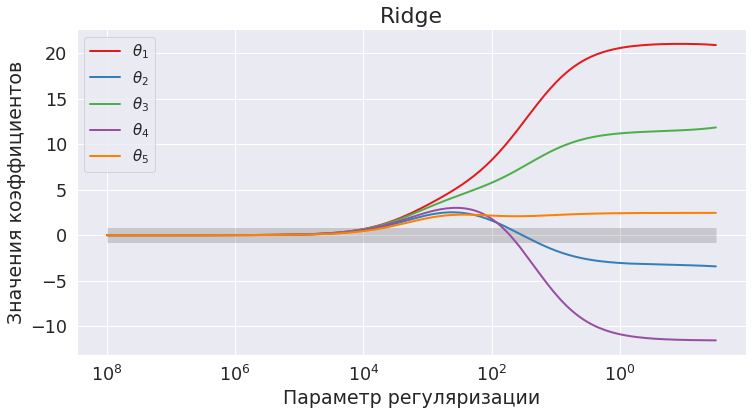

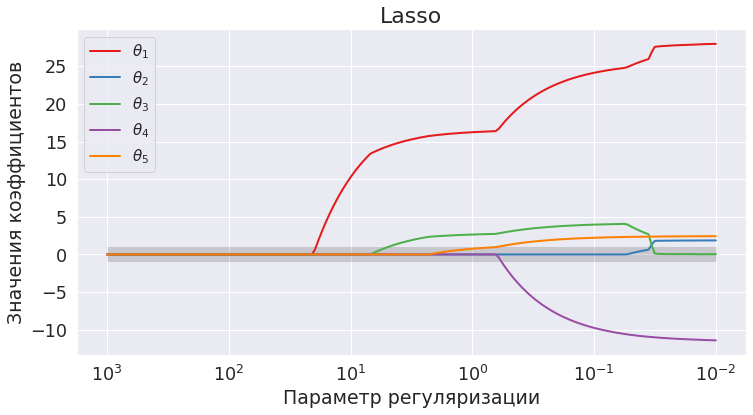

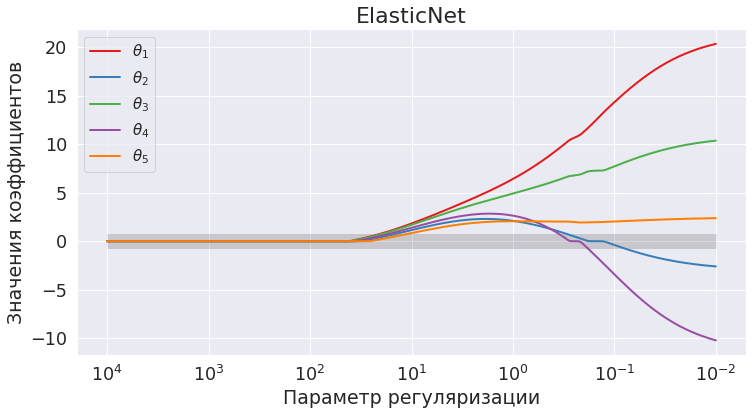

In [8]:
draw_track(Ridge(), X_train_stand, y_train_stand, 
           -1.5, 8, 200, title='Ridge')
draw_track(Lasso(), X_train_stand, y_train_stand, 
           -2, 3, 200, title='Lasso')
draw_track(ElasticNet(l1_ratio=0.5), X_train_stand, y_train_stand, 
           -2, 4, 200, title='ElasticNet')

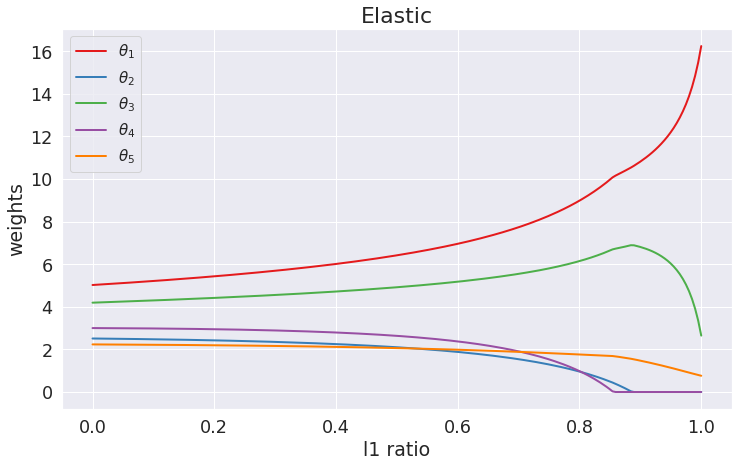

In [9]:
grid = np.linspace(0, 1, 200)   
coefs = []
model = ElasticNet(alpha=1)

for l1_ratio in grid:
    model.set_params(l1_ratio=l1_ratio)
    model.fit(X_train_stand, y_train_stand)
    coefs.append(model.coef_)

plt.figure(figsize=(12, 7))
ax = plt.gca()

ind = 1
for coef in np.array(coefs).T:
    label = r'$\theta_{' + str(ind) + '}$'
    ax.plot(grid, coef, linewidth=2, label=label)
    ind += 1

plt.xlabel('l1 ratio', fontsize=19)
plt.ylabel('weights', fontsize=19)
plt.title("Elastic", fontsize=22)
plt.legend(loc='upper left', fontsize=15)
plt.axis('tight')
plt.show()

Предуположение об оптимальном значении параметра: из графиков выше сложно сделать подобное предположение, так для этого есть методы оптимизации гиперпараметров. На основе графика для Lasso можно сделать выводы о значимости некоторых признаков, так как Lasso отбирает признаки. На основе графика зависимости коэффициентов от параметра `l1_ratio` можно увидеть, что чем больше значение данного параметра, тем более модель склонна к занулению коэффициентов. Это неудивитльно, так как штрафу c l1-нормой дается бОльший приоритет.

Расчитайте индекс обусловленности для случая линейной регрессии. Можно ли сделать вывод о мультиколлинеарности данных?  
Нарисуйте график зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии. 

In [10]:
np.round(np.sqrt(LA.cond(X_train_stand.T @ X_train_stand)), 3)

13000.165

Индекс обусловленности очень большой, данные мультиколлинеарны.

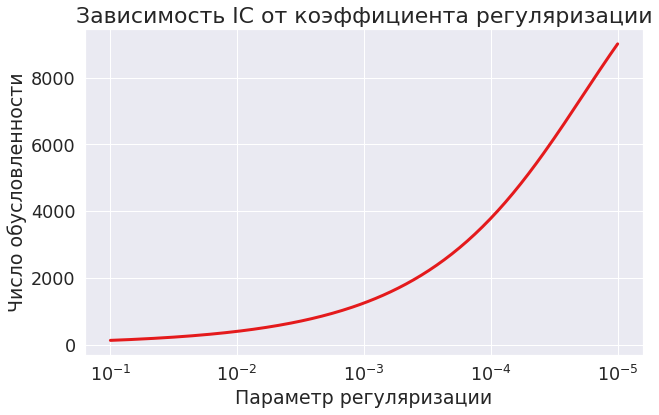

In [11]:
alphas = np.logspace(-5, -1, 200)   
plt.figure(figsize=(10,6))
ax = plt.gca()

ci_list = []
for alpha in alphas:
    ci_list += [np.sqrt(LA.cond(X_train_stand.T @ X_train_stand + alpha*np.eye(X_train_stand.shape[1])))]

ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.plot(alphas, ci_list, linewidth=3)
plt.xlabel('Параметр регуляризации', fontsize=19)
plt.ylabel('Число обусловленности', fontsize=19)
plt.title('Зависимость IC от коэффициента регуляризации', fontsize=22)
plt.axis('tight')
plt.show()

Из графика видно, что чем больше параметр регуляризации, тем меньше индекс обусловленности. 

**3.** С помощью кросс-валидации определите наилучшие параметры для Ridge, Lasso, Elastic моделей. В качестве метрики качества используйте среднеквадратичную ошибку (MSE).

In [12]:
# задаем стратегию кросс-валидации
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

In [13]:
parameters_grid = {
    'clf__alpha' : np.linspace(0.00001, 2, num=100)
}

parameters_grid_elastic = {
    'clf__alpha' : np.linspace(0.00001, 2, num=100),
    'clf__l1_ratio' : np.linspace(0, 1, num=10)
}

Для пайплайна будем использовать не стандартизированные данные, так как они будут стандартизироваться внутри `GridSearch` на первом шаге пайплайна.

In [14]:
models = [Lasso(), Ridge(), ElasticNet()]
best_models = []

for model in models:
    
    steps = [('scaler', StandardScaler()), ('clf', model)] 

    pipeline = Pipeline(steps)  # создаем пайплайн для обучения
    
    if 'l1_ratio' in model.get_params():
        gs = GridSearchCV(estimator=pipeline, 
                          param_grid=parameters_grid_elastic, 
                          scoring='neg_mean_squared_error', 
                          cv=ss)
    else:
        gs = GridSearchCV(estimator=pipeline, 
                          param_grid=parameters_grid, 
                          scoring='neg_mean_squared_error', 
                          cv=ss)
            
    gs.fit(X_train, y_train)
    best_models += [gs.best_estimator_]

На тестовой части данных сравните качество моделей с оптимальными параметрами. Какая модель дала лучший результат?

In [15]:
for model, name in zip(best_models, ['Lasso', 'Ridge', 'Elastic']):
    y_pred = model.predict(X_test)
    print("MSE for {}: {}".format(
        name, np.round(mean_squared_error(y_pred, y_test), 2)
    ))

MSE for Lasso: 33.47
MSE for Ridge: 33.48
MSE for Elastic: 33.47


Лучший результат дали Lasso и Elastic. Неудивительно, потому что пространство поиска для Elastic является надмножеством пространства поиска для Lasso и Ridge. 

**4.** Исследуйте остатки модели Ridge-регрессии. Можно ли говорить о гомоскедастичности. Если нет, попытайтесь несложными преобразованиями признаков и отклика визуально прийти к гомоскедастичности.

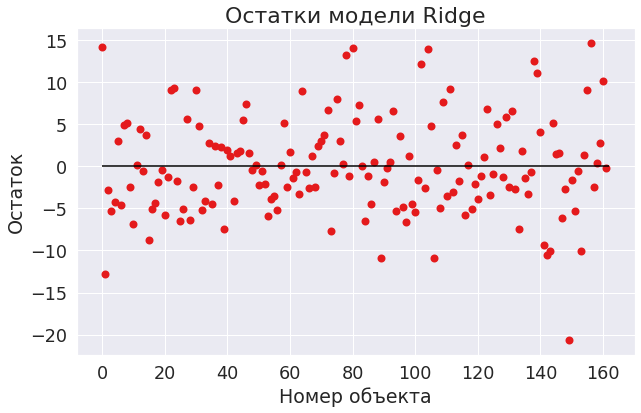

In [16]:
best_ridge = best_models[1]
y_pred = best_ridge.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(np.arange(y_pred.shape[0]), y_pred - y_test, linewidth=2)
plt.xlabel('Номер объекта', fontsize=19)
plt.ylabel('Остаток', fontsize=19)
plt.hlines(0, 0, y_pred.shape[0])
plt.title('Остатки модели Ridge', fontsize=22)
plt.axis('tight')
plt.show()

Ошибки выглядят гомоскедастично. Если бы они так не выглядели, мы могли бы взять логарифмы признаков или целевой переменной, также можно было бы применить преобразования Бокса-Кокса. 

С помощью модели Ridge-регрессии постройте предсказательный интревал для наблюдаемого отклика уровня доверия 0.95. Какой смысл имеет этот интервал? В чем его отличие от доверительного интервала? Посчитате долю точек выходящих за предсказательный интревал.

In [17]:
best_ridge  # лучшая Ridge модель

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 Ridge(alpha=0.02021191919191919, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=None, solver='auto', tol=0.001))],
         verbose=False)

Для построения предиктивных интервалов будем работать со стандартизированными данными.

In [18]:
best_ridge = Ridge(alpha=0.02)
best_ridge.fit(X_train_stand, y_train_stand)

Ridge(alpha=0.02, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [19]:
n = X_train_stand.shape[0]  # количество объектов 
d = X_train_stand.shape[1]  # количество признаков

y_pred = best_ridge.predict(X_train_stand)

b = (n - d) / np.sum((y_pred - y_train_stand) ** 2) 
a = 0.02 * b
sigma = np.linalg.inv(b * X_train_stand.T @ X_train_stand \
                      + a * np.eye(X_train_stand.shape[1]))

In [20]:
left = []
right = []
estimations = []

y_train_stand = np.array(y_train_stand).reshape(-1, 1)
y_test_stand = np.array(y_test_stand).reshape(-1, 1)

outliers_count = 0

for i, x0 in enumerate(X_test_stand):
    x0 = x0.reshape(1, -1)
    y0 = best_ridge.predict(x0)
    x0 = x0.reshape(-1, 1)
    estimations.append(y0)
    
    distr = sps.norm(b * x0.T @ sigma @ X_train_stand.T @ y_train_stand, 
                 np.sqrt(x0.T @ sigma @ x0 + 1 / b))
    
    left.append(distr.ppf(0.975).ravel())
    right.append(distr.ppf(0.025).ravel())
    
    if not (y_test_stand[i] > right[-1][0] and y_test_stand[i] < left[-1][0]):
        outliers_count += 1

In [21]:
print("Доля объектов, не попавших в предиктивный интервал: ", 
      np.round(outliers_count/X_test.shape[0], 2))

Доля объектов, не попавших в предиктивный интервал:  0.06


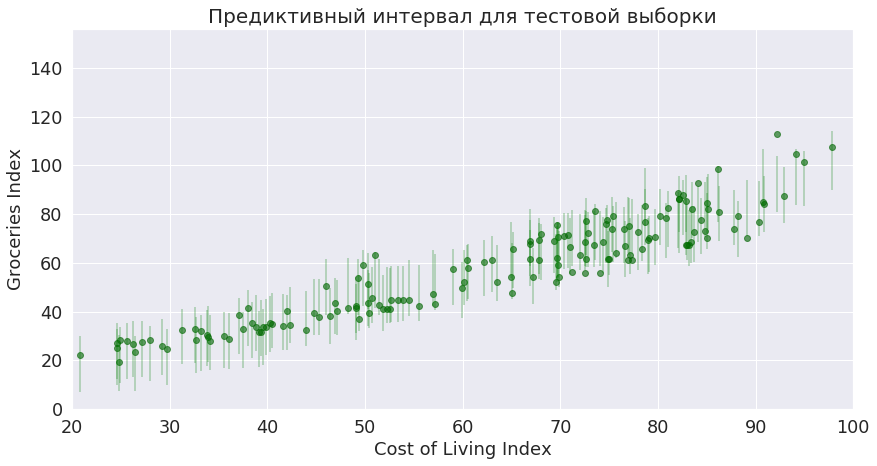

In [22]:
plt.figure(figsize=(14, 7))
plt.scatter(X_test['Cost of Living Index'], y_test, 
            alpha=0.6, color='darkgreen')

plt.vlines(X_test['Cost of Living Index'], 
           y_mean + np.array(left).ravel(), 
           y_mean + np.array(right).ravel(), 
           alpha=0.3, color='green')
    
plt.title('Предиктивный интервал для тестовой выборки', 
          fontsize=20)
plt.xlabel('Cost of Living Index', fontsize=18)
plt.ylabel('Groceries Index', fontsize=18)
plt.xlim(20, 100)
plt.show()

На графике выше в зависимости `Groceries Index` от `Cost of Living Index`  виден линейный тренд. Для каждого объекта построен **свой** предиктивный интервал, поэтому интервалы "скачут". Отличие предиктивного интервала от доверительного заключается в том, что мы учитываем шум (остатки модели). 

**5.** Сделайте общий вывод по задаче.

* При работе с линейными моделями очень важно не забывать стандартизировать признаки.  
* Elastic является удобным компромиссом между Lasso и Ridge, также при значениях параметра `l1_ratio` ноль или единица данная модель эквивалентна Ridge и Lasso соответственно.
* Регуляризация является хорошим методом борьбы с мультиколлинеарностью в Ridge-регрессии.
* При выполнении условий для вероятностного подхода (например, гомоскедастичность остатков) можно строить предиктивные интервалы для новых данных.